## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, utils
from torchvision.io import read_image
import csv
import cv2
import os
from PIL import Image
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Examine the data (EDA)
I used Python's built-in <a href='https://docs.python.org/3/library/os.html'>os module</a> to walk the directories collecting file names and then I used the <a href='https://python-pillow.org/'>Pillow</a>, an extension to the Python Imaging Library (PIL), to open image files and extract image sizes. A pandas DataFrame provides the summary statistics on the data like max/min width & height on the basis of which I chose my model parameters.

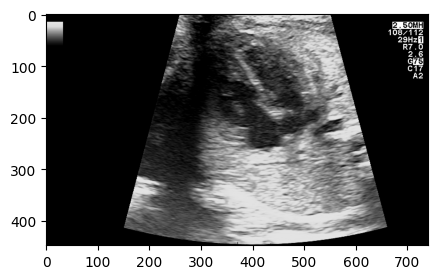

In [3]:
plt.figure(figsize = (20,3))
with Image.open(r'Data\Task_1\train_images\Patient00168_Plane6_1_of_4.png') as im:
    plt.imshow(im, cmap='gray')

In [4]:
# check the sizes of the train dataset

path = r'Data\Task_1\train_images'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'\\'+img)

img_sizes = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        pass
        
df = pd.DataFrame(img_sizes)

In [5]:
# summary statistics on image widths
df[0].describe()

count    1646.000000
mean      918.077764
std       149.755196
min       640.000000
25%       959.000000
50%       959.000000
75%       959.000000
max      1495.000000
Name: 0, dtype: float64

In [6]:
# summary statistics on image heights
df[1].describe()

count    1646.000000
mean      613.954435
std       123.342821
min       392.000000
25%       496.000000
50%       661.000000
75%       661.000000
max       787.000000
Name: 1, dtype: float64

This tells us the shortest width is 640, the shortest height is 392, the largest width and height are 1495 and 787 resp. This is useful for deciding on an input size. I have chosen 224x224 as my input image size, so I will use some transforms to scale the images uniformly

In [7]:
with open('Data\Task_1\image_label.csv', mode='r', newline='', encoding='utf-8') as f: # load csv as dictionary
    reader = csv.reader(f)
    gt = {rows[0]:rows[1] for rows in reader}

path_train = r'Data\Task_1\train_images'
train_labels_df = []
for root, dirs, files in os.walk(path_train):
    for file in files:
        with open(os.path.join(root, file), "r") as auto:
            target = gt[file[:-4]]
            train_labels_df.append((file, target))

In [8]:
train_df = pd. DataFrame(train_labels_df, columns=['Image', 'Class'])
labels_map = { "Class": {"Fetal thorax": 0.0, "Fetal femur": 1.0, "Fetal abdomen": 2.0, "Fetal brain": 3.0}}

In [9]:
train_df = train_df.replace(labels_map)
train_df.head()

,Image,Class
0,Patient00168_Plane6_1_of_4.png,0.0
1,Patient00188_Plane5_1_of_1.png,1.0
2,Patient00216_Plane6_2_of_3.png,0.0
3,Patient00305_Plane2_1_of_2.png,2.0
4,Patient00305_Plane3_1_of_5.png,3.0


# 3 Methods used: Resnet50, AlexNet, Custom CNN Model

## 1. Using Pretrained Model: ResNet50

In [10]:
# greyscale images are 1 channel and pretrained networks require 3 channels hence I'm defining new transforms

pre_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)      
    ])

In [11]:
# create torch dataset for our given data

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, train_dataset, img_dir, transform, target_transform=None):
        self.img_labels = train_dataset
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
my_pre_df = CustomImageDataset(train_df, r'Data\Task_1\train_images', pre_transform)
my_pre_df

In [13]:
train_data, val_data = torch.utils.data.random_split(my_pre_df, [1316, 330])
print("The length of train data is:", len(train_data))
print("The length of test data is:", len(val_data))

The length of train data is: 1316
The length of test data is: 330


In [14]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=False)

In [15]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 3, 224, 224])
Labels batch shape: torch.Size([10])


In [16]:
# import pretrained resnet model from torchvision models

rsn_model = torchvision.models.resnet50(pretrained=True)

In [17]:
#freeze weights

for param in rsn_model.parameters():
    param.requires_grad = False

In [18]:
# model final classifier to have 4 classes

torch.manual_seed(42)
rsn_model.fc = nn.Linear(in_features=2048, out_features=4, bias=True)
rsn_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rsn_model.fc.parameters(), lr=0.001)

In [20]:
# train the data

import time
start_time = time.time()

epochs = 3

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_train = y_train.type(torch.LongTensor)
        
        # apply the resnet model
        y_pred = rsn_model(X_train.type(torch.FloatTensor))
        loss = criterion(y_pred, y_train)
 
        # tallying the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i+1:2} batch: {b:4} [{10*b:6}/1316] loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # running the validation batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            
            y_test = y_test.type(torch.LongTensor)
            y_val = rsn_model(X_test.type(torch.FloatTensor))

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  1 batch:   10 [   100/1316] loss: 1.35310411 accuracy:  18.000%
epoch:  1 batch:   20 [   200/1316] loss: 0.99406803 accuracy:  29.000%
epoch:  1 batch:   30 [   300/1316] loss: 0.87982160 accuracy:  34.000%
epoch:  1 batch:   40 [   400/1316] loss: 0.79317248 accuracy:  36.250%
epoch:  1 batch:   50 [   500/1316] loss: 1.01497436 accuracy:  39.800%
epoch:  1 batch:   60 [   600/1316] loss: 1.11558986 accuracy:  44.667%
epoch:  1 batch:   70 [   700/1316] loss: 0.91577929 accuracy:  47.857%
epoch:  1 batch:   80 [   800/1316] loss: 0.69516081 accuracy:  50.500%
epoch:  1 batch:   90 [   900/1316] loss: 0.53156263 accuracy:  51.667%
epoch:  1 batch:  100 [  1000/1316] loss: 1.39125979 accuracy:  52.700%
epoch:  1 batch:  110 [  1100/1316] loss: 0.96524704 accuracy:  54.091%
epoch:  1 batch:  120 [  1200/1316] loss: 1.09075820 accuracy:  55.250%
epoch:  1 batch:  130 [  1300/1316] loss: 0.55511522 accuracy:  56.538%
epoch:  2 batch:   10 [   100/1316] loss: 0.63200635 accuracy:  

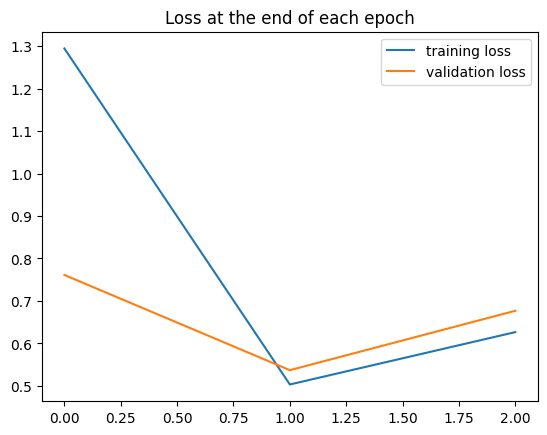

In [21]:
# plot the loss comparisons

with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

## 2. Using Pretrained Model: AlexNet

In [22]:
# import pretrained alexnet model from torchvision models

alx_model = torchvision.models.alexnet(pretrained=True)
alx_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
#freeze weights

for param in alx_model.parameters():
    param.requires_grad = False

In [24]:
# model final classifier to have 4 classes

torch.manual_seed(42)
alx_model.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 4),
                                 nn.LogSoftmax(dim=1))
alx_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [25]:
# define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alx_model.classifier.parameters(), lr=0.001)

In [26]:
# train the data

import time
start_time = time.time()

epochs = 3

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_train = y_train.type(torch.LongTensor)
        
        # apply the alexnet model
        y_pred = alx_model(X_train.type(torch.FloatTensor))
        loss = criterion(y_pred, y_train)
 
        # tallying the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i+1:2} batch: {b:4} [{10*b:6}/1316] loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # running the validation batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            
            y_test = y_test.type(torch.LongTensor)
            y_val = alx_model(X_test.type(torch.FloatTensor))

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  1 batch:   10 [   100/1316] loss: 13.24209595 accuracy:  47.000%
epoch:  1 batch:   20 [   200/1316] loss: 46.05024338 accuracy:  49.000%
epoch:  1 batch:   30 [   300/1316] loss: 14.10243797 accuracy:  51.333%
epoch:  1 batch:   40 [   400/1316] loss: 24.20680618 accuracy:  53.750%
epoch:  1 batch:   50 [   500/1316] loss: 25.47591972 accuracy:  57.200%
epoch:  1 batch:   60 [   600/1316] loss: 13.33337688 accuracy:  60.500%
epoch:  1 batch:   70 [   700/1316] loss: 0.00060500 accuracy:  62.857%
epoch:  1 batch:   80 [   800/1316] loss: 2.80019855 accuracy:  63.875%
epoch:  1 batch:   90 [   900/1316] loss: 11.07766247 accuracy:  64.222%
epoch:  1 batch:  100 [  1000/1316] loss: 2.34677744 accuracy:  64.400%
epoch:  1 batch:  110 [  1100/1316] loss: 6.71567678 accuracy:  64.545%
epoch:  1 batch:  120 [  1200/1316] loss: 5.55865717 accuracy:  64.917%
epoch:  1 batch:  130 [  1300/1316] loss: 4.12490845 accuracy:  65.462%
epoch:  2 batch:   10 [   100/1316] loss: 0.31493124 accu

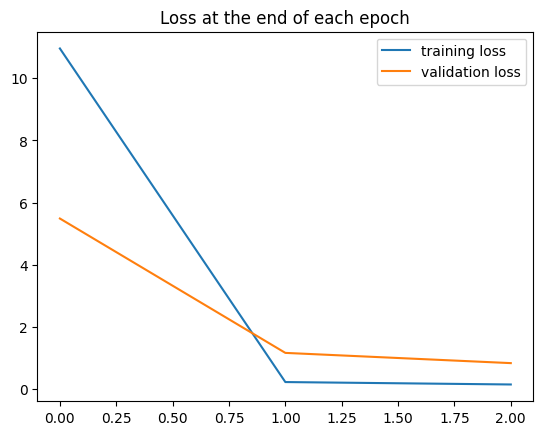

In [27]:
# plot the loss comparisons

with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

## 3. Custom CNN Model

In [28]:
# define transformations

cnn_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.CenterCrop(224)
    ])

In [29]:
my_df = CustomImageDataset(train_df, r'Data\Task_1\train_images', cnn_transform)
len(my_df)

1646

In [30]:
# split the train data into train and validation sets

train_data, val_data = torch.utils.data.random_split(my_df, [1316, 330])
print("The length of train data is:",len(train_data))
print("The length of validation data is:",len(val_data))

The length of train data is: 1316
The length of validation data is: 330


In [31]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=False)

In [32]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 1, 224, 224])
Labels batch shape: torch.Size([10])


Label: [1. 3. 0. 3. 3. 1. 0. 0. 3. 2.]


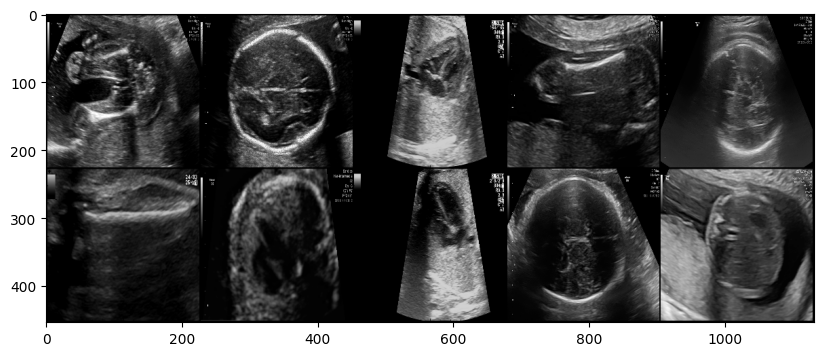

In [33]:
# display the first batch of images and their labels from our dataset

for images,labels in train_loader: 
    break
print('Label:', labels.numpy())

im = torchvision.utils.make_grid(images, nrow=5)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [34]:
# defining my custom cnn model

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,4)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [35]:
torch.manual_seed(42)
cnn_model = ConvolutionalNetwork()
cnn_model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [36]:
# define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [37]:
# train the data

import time
start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        y_train = y_train.type(torch.LongTensor)
        
        # applying my model
        y_pred = cnn_model(X_train.type(torch.FloatTensor))  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%10 == 0:
            print(f'epoch: {i+1:2}  batch: [{10*b:6}/1316] loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # running the validation batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            
            y_test = y_test.type(torch.LongTensor)
            y_val = cnn_model(X_test.type(torch.FloatTensor))
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')           

epoch:  1  batch: [   100/1316] loss: 27.74570274 accuracy:  29.000%
epoch:  1  batch: [   200/1316] loss: 9.27789497 accuracy:  31.500%
epoch:  1  batch: [   300/1316] loss: 3.15754485 accuracy:  36.667%
epoch:  1  batch: [   400/1316] loss: 2.00860834 accuracy:  38.250%
epoch:  1  batch: [   500/1316] loss: 1.87187672 accuracy:  41.200%
epoch:  1  batch: [   600/1316] loss: 0.46222776 accuracy:  43.667%
epoch:  1  batch: [   700/1316] loss: 0.62543106 accuracy:  47.857%
epoch:  1  batch: [   800/1316] loss: 1.14421129 accuracy:  50.375%
epoch:  1  batch: [   900/1316] loss: 0.73758829 accuracy:  52.444%
epoch:  1  batch: [  1000/1316] loss: 0.73334825 accuracy:  53.900%
epoch:  1  batch: [  1100/1316] loss: 1.08724928 accuracy:  55.364%
epoch:  1  batch: [  1200/1316] loss: 0.58572477 accuracy:  56.917%
epoch:  1  batch: [  1300/1316] loss: 0.86723602 accuracy:  58.000%
epoch:  2  batch: [   100/1316] loss: 0.37918696 accuracy:  85.000%
epoch:  2  batch: [   200/1316] loss: 0.9430327

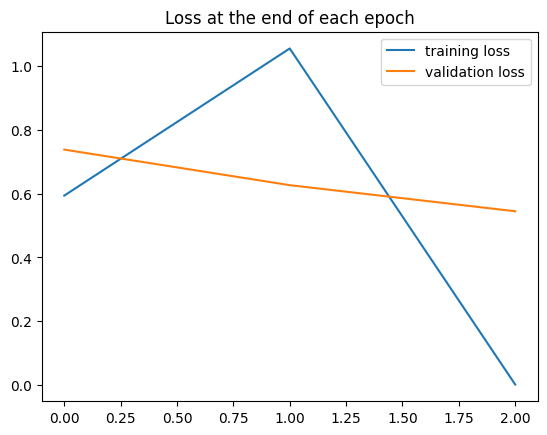

In [38]:
# plot the loss comparisons

with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

In [39]:
torch.save(cnn_model.state_dict(), 'CNN-Model-Task-1.pt')

In [40]:
torch.save(rsn_model.state_dict(), 'ResNet-Model-Task-1.pt')

In [41]:
torch.save(alx_model.state_dict(), 'AlexNet-Model-Task-1.pt')

## Run unseen test images through the model

In [46]:
path_test = r'Data\Task_1\test_images'

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
    ])

test_path_df = []
for root, dirs, files in os.walk(path_test):
    for file in files:
        with open(os.path.join(root, file), "r") as auto:
            image = read_image(path_test + "\\" + file)
            image = test_transform(image)
            test_path_df.append(image)

In [47]:
torch.manual_seed(42)
eval_df = DataLoader(test_path_df, batch_size=1, shuffle=False)

In [48]:
class_names = ["Fetal thorax", "Fetal femur", "Fetal abdomen", "Fetal brain"]

In [49]:
predictions = []

rsn_model.eval()
with torch.no_grad():
    for b in eval_df:
        new_pred = rsn_model(b.type(torch.FloatTensor))
        predicted_idx = torch.max(new_pred, 1)
        predicted_label = class_names[predicted_idx[1]]
        predictions.append((b, predicted_label))

print(len(predictions))

40


1 ['Fetal thorax', 'Fetal abdomen', 'Fetal brain', 'Fetal thorax', 'Fetal brain']

2 ['Fetal brain', 'Fetal thorax', 'Fetal brain', 'Fetal femur', 'Fetal brain']

3 ['Fetal brain', 'Fetal brain', 'Fetal thorax', 'Fetal brain', 'Fetal brain']

4 ['Fetal brain', 'Fetal brain', 'Fetal femur', 'Fetal femur', 'Fetal abdomen']

5 ['Fetal femur', 'Fetal brain', 'Fetal brain', 'Fetal abdomen', 'Fetal brain']

6 ['Fetal brain', 'Fetal thorax', 'Fetal brain', 'Fetal brain', 'Fetal abdomen']

7 ['Fetal brain', 'Fetal thorax', 'Fetal brain', 'Fetal thorax', 'Fetal brain']

8 ['Fetal brain', 'Fetal femur', 'Fetal femur', 'Fetal brain', 'Fetal thorax']



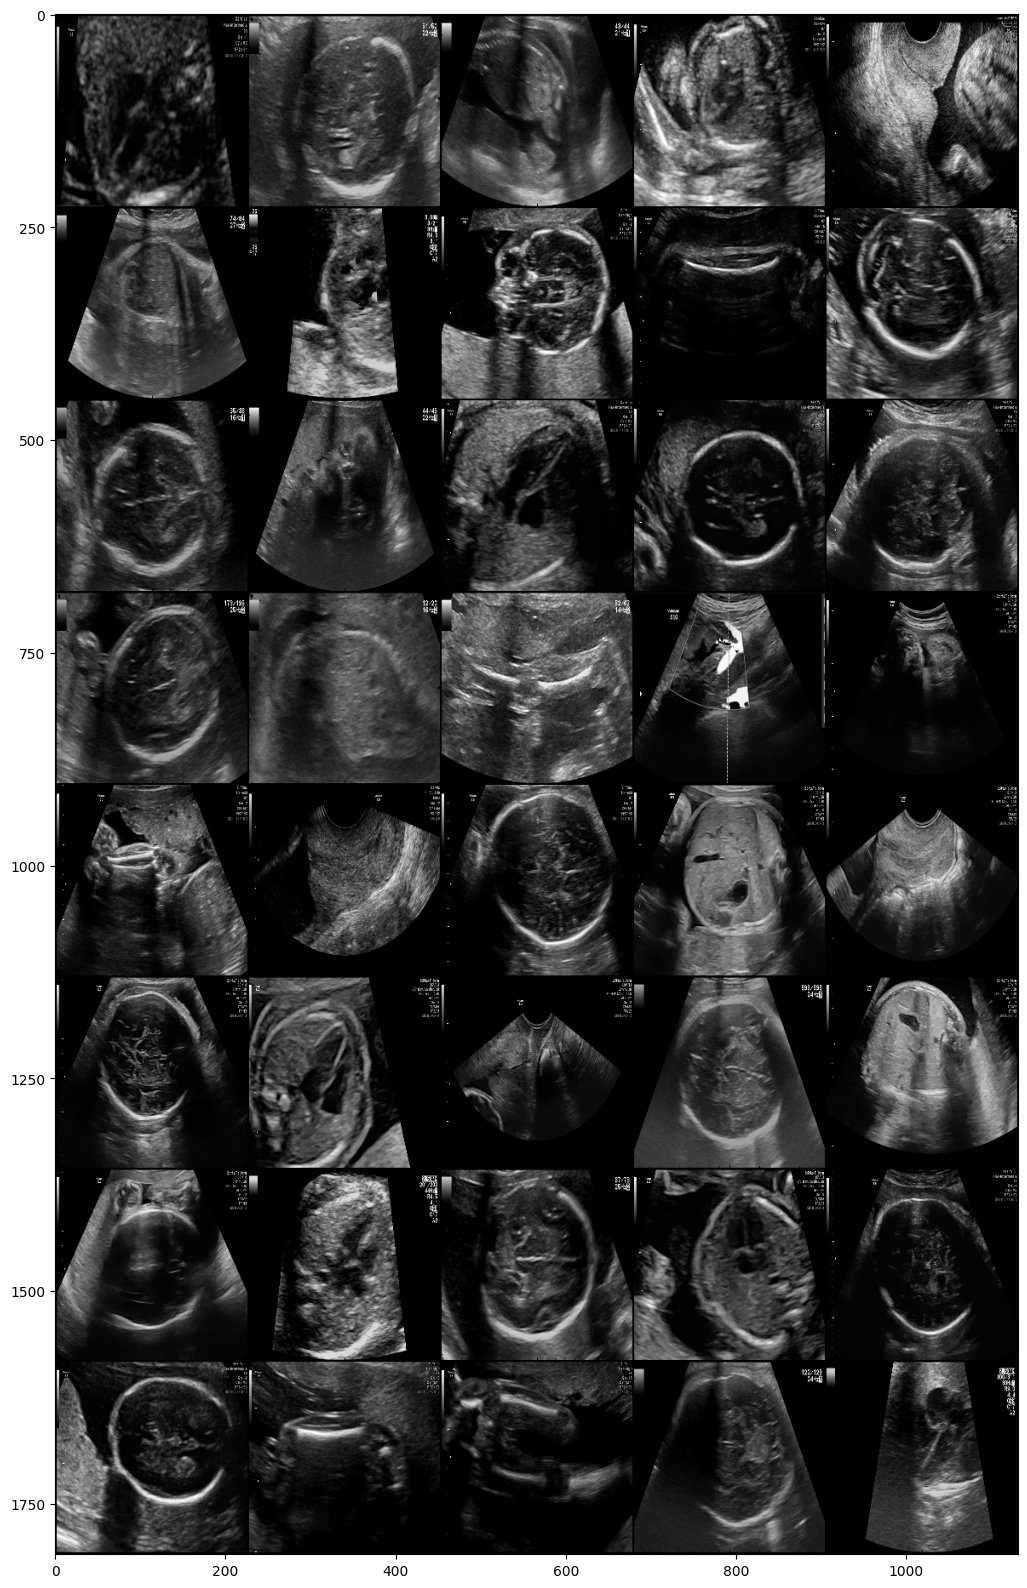

In [50]:
pred_imgs = []
lbls = []
for images, label in predictions:
    pred_imgs.append(images[0])
    lbls.append(label)

sec_lbls = [lbls[i:i + 5] for i in range(0, len(lbls), 5)]
for i, j in enumerate(sec_lbls):
    print(i+1, j)
    print()

rev_transform = transforms.Grayscale(num_output_channels=1)
trnsf = [rev_transform(i) for i in pred_imgs]

im = torchvision.utils.make_grid(trnsf, nrow=5)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));